# Development of the Linear Model

Previously, the data-set has been explored. In the following, the linear model will be developed. While working on this originally, just before the linear model was started, I attempted the preprocessing. This is outlined in the preprocessing section.


These are the preprocessing and quality control pipelines used:

Quality controle was performed using the [Magnetic Resoncance Imaging Quality Controle pipeline](https://mriqc.readthedocs.io/en/latest/) (22.0.6). 

The preprocessing was performed using [fMRI-Prep](https://fmriprep.org/en/stable/) (20.2.3)

## Preparation

In [1]:
#Import of things I need later:
import os
import numpy as np
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
import warnings

Fistly I will load a preprocessed image. Then, going from the previously explored event files, I will briefly mention the experimental paradigm again. These will then be used for a generalized linear model (GLM).

I will first do the linear model for subject 6 to see if everything works (this subject was used as an example as it was the first participant with data for all runs).  

In [2]:
#File paths
file_path = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data"
fmri_img_run1_sub06_path = os.path.join(file_path, "outputs/fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_bold.nii.gz")
anat__img_run1_sub06_path = os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_T1w.nii.gz")

I have now the file paths to the mri images. Now I still need the event files to define respective contrasts. 


In [3]:
events_run1_sub06_path = os.path.join(file_path,"ds003707", "sub-06", "func", "sub-06_task-scene_run-01_events.tsv")

import pandas as pd
events_run1_sub06 = pd.read_table(events_run1_sub06_path)

events_run1_sub06

,onset,duration,correct,trial_type,response_time
0,10,4,0.0,1_A9,NaN
1,14,4,1.0,1_A2,1.486898
2,18,4,1.0,1_A1,0.752162
3,22,4,1.0,1_B4,0.334689
4,26,4,1.0,1_B0,0.368064
...,...,...,...,...,...
73,324,4,0.0,2_B16,NaN
74,328,4,1.0,foil05,0.735685
75,332,4,1.0,2_A17,0.534958
76,336,4,1.0,foil03,0.785550


In [4]:
events_run1_sub06 = events_run1_sub06[["onset", "duration", "trial_type"]]
for i, row in events_run1_sub06.iterrows():
    events_run1_sub06["trial_type"][i] = events_run1_sub06["trial_type"][i].replace('1_', 'Learned_')
    events_run1_sub06["trial_type"][i] = events_run1_sub06["trial_type"][i].replace('2_', 'Learned_')
    
warnings.filterwarnings('ignore')

/home/tchaase/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tchaase/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/tchaase/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

Each trial has a certain onset, the same duration and then the response is either correct or not correct. 
We also see that there is a certain response time - if this is failed the trial is listed to be `0.0` i.e. not correct. 


Now, lets generate a design matrix with these event files. Recall that a 'design matrix' is a matrix that contains the explanatory variables. Here, the explanatory variables also involes the regressors that are the result of the previously mentioned pipelines!

## First-Level Model

First, before I can generate a `FirstLevelModel`, I need to extract the repetion time.

In [5]:
from nilearn.glm.first_level import FirstLevelModel

#Now I need the TR and other parameters. I previously extracted them using the 'pybids module! Here I will take also show a different attempt:

import nibabel as nib ;

fmri_img_run1_sub06 = nib.load(fmri_img_run1_sub06_path);
#The get_zooms function contains voxel size with the 4th entry being the time, this is therefore the repetiton time!
fmri_img_run1_sub06.header.get_zooms()[3]

2.0

Knowing the repition time, we can set up the `FirstLevelModel`.

Briefly explained, I understand a first level model as a first step used to generate the linear models later - there are certain things like the haemondynamic response that needs to be modelled, which will be done in this first step!

Here is an explanation on the parameters:
- `T_r` refers to the repetion time, this was extracted above. 
- `Drift mode`: It's a `cosine functio` that aims to remove effects of heart rate etc. The standard setting here is 1/128 Hz. In the design matrix this will end up as a column with almost no change in color, only very slight drift!
- The `hrf-model` part specifies the`hemodynamic response model`: The event file has certain events, but this needs to be converted into a ["reference BOLD signal for the design matrix"](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html). Here the basic wasn't choosen, but the `spm`. This stands for statistical parametric map. In contrast to the basic the undershoot following the haemondynamic response is said to be weaker here.
- Fruthermore, a `high pass filter` can be applied. The high pass filter will let [higher frequencies pass](https://www.brainvoyager.com/bv/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html), the cut-off here is set to another value than the standard! What does this mean? I will have an additional confound with the lower frequencies, them being included in the model instead of them being removed!
&nbsp;


- `noise_model`: There are different options for noise models. The `ar1` is the preset noise model. A ordinary least squared approach, autoregressive approaches of higher order or other models could have been used. 
&nbsp;


- I don't want the signal to be scaled, so this is set to false!

In [6]:
fmri_glm = FirstLevelModel(t_r=2.0,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./128,
                           signal_scaling=False,
                           minimize_memory =  False)

This model still lacks the confounds.

In [32]:
import pandas as pd
import numpy as np
confounds_run1_sub06 = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-confounds.tsv"), 
                                  delimiter = '\t')
#The delimiter needs to be set to \t as it uses tab to differentiate different entries. 

column_names = list(confounds_run1_sub06.columns.values)
column_names

['global_signal',
 'global_signal_derivative1',
 'global_signal_power2',
 'global_signal_derivative1_power2',
 'csf',
 'csf_derivative1',
 'csf_derivative1_power2',
 'csf_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_power2',
 'white_matter_derivative1_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 'rmsd',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 't_comp_cor_05',
 't_comp_cor_06',
 't_comp_cor_07',
 't_comp_cor_08',
 't_comp_cor_09',
 't_comp_cor_10',
 't_comp_cor_11',
 't_comp_cor_12',
 't_comp_cor_13',
 'a_comp_cor_00',
 'a_comp_cor_01',
 'a_comp_cor_02',
 'a_comp_cor_03',
 'a_comp_cor_04',
 'a_comp_cor_05',
 'a_comp_cor_06',
 'a_comp_cor_07',
 'a_comp_cor_08',
 'a_comp_cor_09',
 'a_comp_cor_10',
 'a_comp_cor_11',
 'a_comp_cor_12',
 'a_comp_cor_13',
 'a_comp_cor_14',
 'a_comp_cor_15',
 'a_comp_cor_16',
 'a_comp_cor_17',
 'a_comp_cor_18',
 'a_comp_cor_19',
 'a_comp_cor_20',


Only a portion of the entries are needed here. 

The following are extracted, following the recommedation from the [fmriprep-doc](https://fmriprep.org/en/stable/outputs.html#confounds). 
- The parameters of head motion, i.e. the transverse and rotational movements. `trans_x`, `trans_y`, `trans_z`, `rot_x`, `rot_y`, `rot_z`.

&nbsp;
The following three are copy-pastad from said website:
- `csf - the average signal within anatomically-derived eroded CSF mask`
- `white_matter - the average signal within the anatomically-derived eroded WM masks`
-  `global_signal - the average signal within the brain mask`

- the rmsd - this also takes head motion into account but using a different statistical approach.
- framewise_displacement - another classic measure of movement. 

As a high-pass filter is included, I will not include regressors for signal drift. 

In [8]:
confounds_glm_run1_sub06 = confounds_run1_sub06[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
confounds_glm_run1_sub06

,white_matter,global_signal,framewise_displacement,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,rmsd
0,5975.756217,6126.668641,0.000000,10444.063602,0.034271,-0.011028,0.033954,-9.374490e-05,-0.000297,0.000453,0.000000
1,5978.942933,6126.743570,0.025447,10346.109765,0.027841,-0.012104,0.039323,-1.323490e-23,-0.000346,0.000343,0.011883
2,5980.483029,6132.032324,0.033753,10362.884937,0.033482,-0.003517,0.024437,0.000000e+00,-0.000337,0.000259,0.018279
3,5978.650057,6129.665218,0.036861,10217.434957,0.028032,0.007799,0.031598,-1.201740e-04,-0.000375,0.000158,0.017710
4,5976.735798,6126.883741,0.042074,10232.444192,0.025611,-0.012633,0.035864,-2.646980e-23,-0.000372,0.000334,0.023282
...,...,...,...,...,...,...,...,...,...,...,...
172,5967.351326,6132.775404,0.052491,10434.865707,-0.027287,0.028218,-0.022084,-1.446660e-04,-0.001686,-0.000312,0.027091
173,5968.436398,6133.940994,0.070713,10374.021769,-0.025793,0.058979,-0.031075,-5.428840e-04,-0.001758,-0.000193,0.038925
174,5971.929799,6125.377610,0.017491,10288.476298,-0.022662,0.057221,-0.036650,-5.242960e-04,-0.001830,-0.000142,0.008184
175,5971.281566,6122.549079,0.064655,10343.196182,-0.020640,0.030443,-0.018628,-3.507080e-04,-0.001647,-0.000142,0.034101


I have now specified the confounds I will need. 


Below, there is one step that only works with never versions of nilearn (0.9.2. and newer) but is not necessary here. The event files only start after 5 volumes, meaining with a repetition time of 2 after 10 seconds. 
A sample mask can be used to remove them, which is an option I am not going to do to make it easier to analyse a lot of files later fast and thus remove one unnecessary analyses steps. 

In [9]:
import nilearn.image as nli

#Loading the image to get the amount of volumes.
sub06_run1_bold = nli.load_img(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-06", "sub-06_task-scene_run-01_desc-preproc_bold.nii.gz"))
sub06_run1_bold_mask = np.arange((sub06_run1_bold.get_fdata().shape[3]))[5:]  
#creating an array with the amount entries equaling volumes except the first 10 seconds / 5 volumes. 
# just another way besides looking at the .json! Although a one with longer loading times!
sub06_run1_bold_mask

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176])

Now lets run the model!

In [10]:
fmri_glm_run1_sub06 = fmri_glm.fit(fmri_img_run1_sub06_path, events = events_run1_sub06, \
                                          # sample_masks = sub06_run1_bold_mask, \ removed
                                          confounds = confounds_glm_run1_sub06)

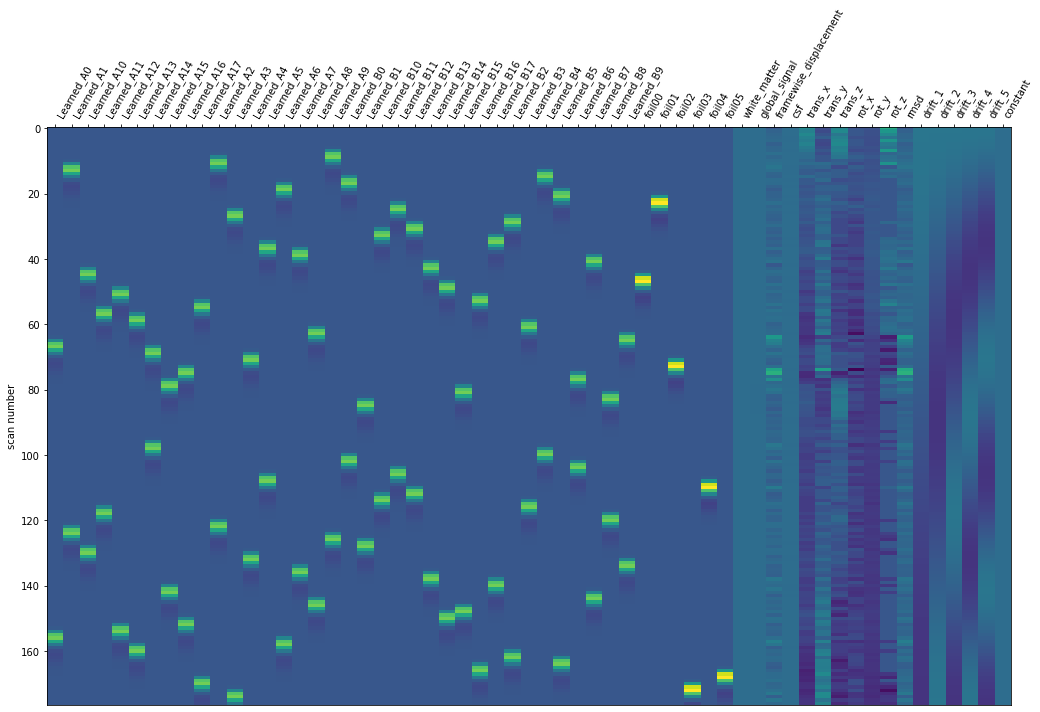

In [11]:
design_matrix = fmri_glm_run1_sub06.design_matrices_[0]

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

There was 36 objects or scenes. Each was repeated twice per run. There were 18 object scene pairmates as explained in the data exploration. 

Let's save this design matrix!

In [12]:
outdir = 'results'
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/")

if not os.path.exists(outdir):
    os.mkdir(outdir)


from os.path import join
plot_design_matrix(design_matrix, output_file=join(outdir, 'design_matrix.png'))

outdir_path = os.path.join(file_path, "outputs", "results")

I am already creating an output folder for participant 6.

In [13]:
if not os.path.exists(os.path.join(outdir_path, "sub-06")):
    os.mkdir(os.path.join(outdir_path, "sub-06"))
else: 
    print("This one already exists!")

This one already exists!


To ensure this works, I want to inspect the expected response for a random item. 

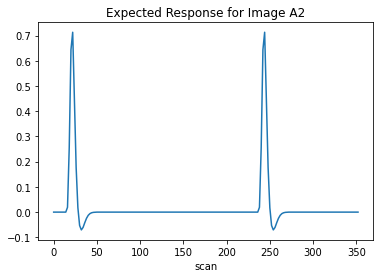

In [14]:
plt.plot(design_matrix['Learned_A2']) 
plt.xlabel('scan')
plt.title('Expected Response for Image A2')
plt.show()

Thus far everything seems to work as intended. 

Now I want to identify voxels that have significant effects within the next section.

## Detection of Significant Voxels

Firstly, I will need to get the betas for every voxel. To achieve this, I need to first get the contrasts. These will require some data wrangling, which will be done in the following. 

In [15]:
from numpy import array
array_learned = np.array([0]*design_matrix.shape[0])
                            
conditions = {
    'active - Learned': np.array([0]*design_matrix.shape[1]),
    'active - Foil':   np.array([0]*design_matrix.shape[1]),
}

In [16]:
i = 0
for col in design_matrix:
    if "foil" in col:     #Creating the contrast for the lure images. 
        conditions['active - Foil'][i] = 1
    elif "Learned_A" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    elif "Learned_B" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    i = i+1   

Let's have a look at the conditions and see if it worked.

In [17]:
conditions

{'active - Learned': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'active - Foil': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

Above, I have created some first contrasts to test the rest of the glm. If this works, I may change it according to what I wanted to do initially!

Here is the contrast for the learned images:

<AxesSubplot:label='conditions'>

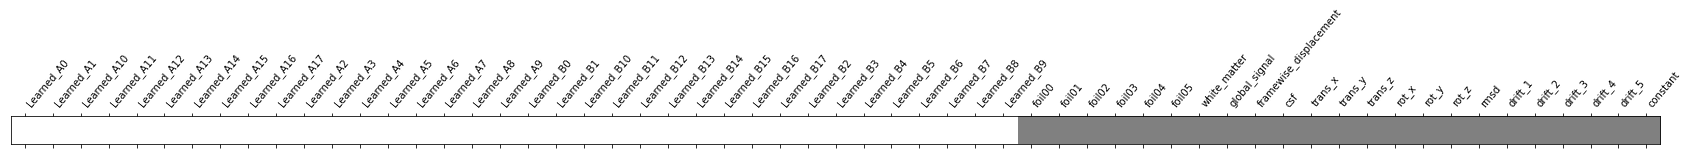

In [18]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Learned'], design_matrix=design_matrix)

Here is the contrast for the lures. 

<AxesSubplot:label='conditions'>

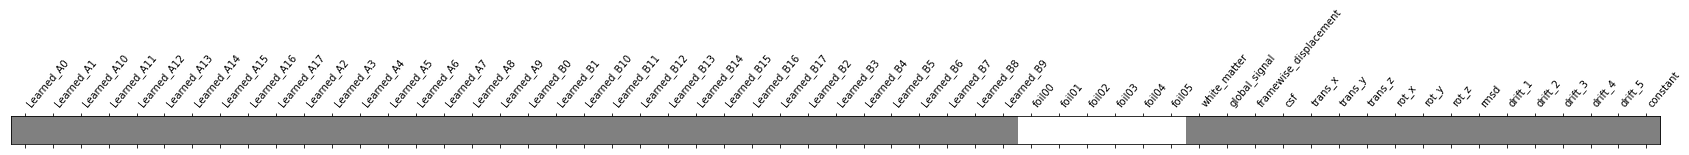

In [19]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Foil'], design_matrix=design_matrix)

The contrast I would like to take is the learned images vs the foils. The contrasts are therefore:

<AxesSubplot:label='conditions'>

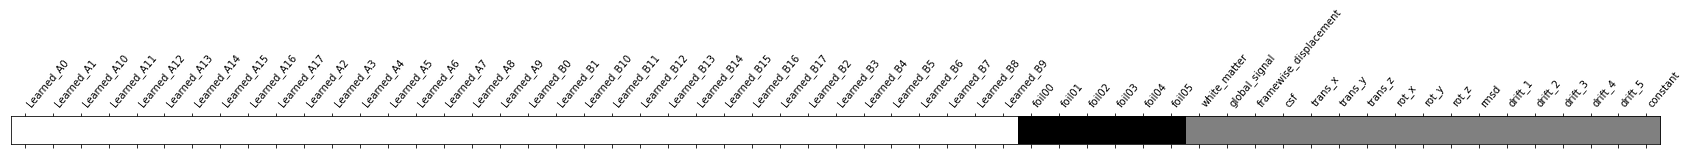

In [20]:
active_learned_vs_foil = conditions['active - Learned'] - conditions['active - Foil']
plot_contrast_matrix(active_learned_vs_foil, design_matrix=design_matrix)

In [21]:
eff_map = fmri_glm_run1_sub06.compute_contrast(active_learned_vs_foil,
                                    output_type='effect_size')

This shows the estimated effects without involving any corrections for the variation. 

The next plot contains the z-map. Here, we use z scores that are approximated by t-values. As mentioned before, the functional image is cut off. The treshold is choosen arbitraily following the preset value in nilearn's example.

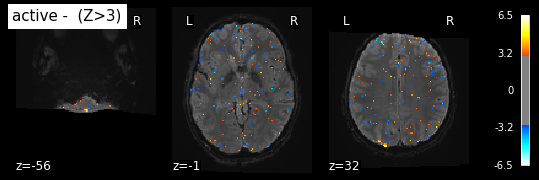

In [22]:
z_map_sub06_run1 = fmri_glm_run1_sub06.compute_contrast(active_learned_vs_foil,
                                  output_type='z_score')

#Get the mean image
from nilearn.image import mean_img
mean_img_run1_sub06 = mean_img(fmri_img_run1_sub06_path)

plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active -  (Z>3)')
plt.show()

This is the z-map with a treshold of the false-discovery rate: It's set to 0.001 for all the significant voxels together. This is what's meant by `fpr`, it stands for the control for the false recovery rate. 

Uncorrected p<0.001 threshold: 3.291


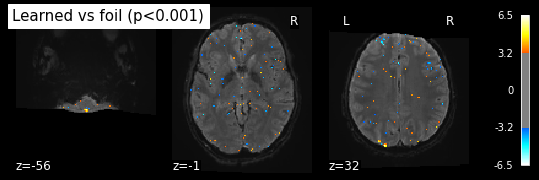

In [23]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map_sub06_run1, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,title= 'Learned vs foil (p<0.001)')
plt.show()

And here I correct for multiple comperison. The family wise error is corrected using the Bonferroni-correction. 

Bonferroni-corrected, p<0.05 threshold: 5.259


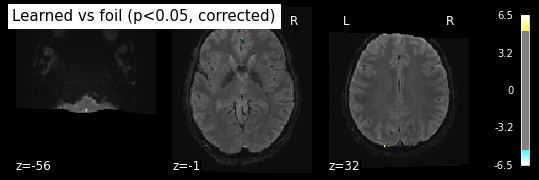

In [24]:
_, threshold = threshold_stats_img(
    z_map_sub06_run1, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map_sub06_run1, bg_img=mean_img_run1_sub06, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Learned vs foil (p<0.05, corrected)')
plt.show()

Having displayed the different options, I am going for the following:
  - I am interested in smaller clusters, for example within the hippocampus. I will therefore choose a smaller cluster treshold. \
      &rarr; Furthermore, FDR-correction should, correct for the increase in voxels with no exclusion of smaller clusters.     
    
  - I do want to correct for the multiple comparisons, as a trade-off between being rather conservative (Bonferonni) and a rather liberal approach (controlling for the false-positive rate), I want to control for the proportion of false discoveries among the deteced values. 
  
The correction for the false discovery rate controls for the the number of false positives among the subset of voxels that are significant (Genovese, 2002). 

False Discovery rate = 0.001 threshold: 3.291


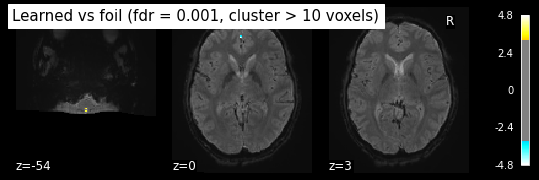

In [25]:
clean_map, threshold = threshold_stats_img(z_map_sub06_run1, alpha=.001, height_control='fpr', cluster_threshold= 10)
print('False Discovery rate = 0.001 threshold: %.3f' % threshold)
plot_stat_map(clean_map, bg_img=mean_img_run1_sub06, threshold = threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Learned vs foil (fdr = 0.001, cluster > 10 voxels)')
plt.show()

#Saving the z-map for future use:
z_map_sub06_run1.to_filename(os.path.join(outdir, 'sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz'))


Let's extract any significant voxels from the above image and look at them. 

In [26]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map_sub06_run1, stat_threshold=threshold,
                           cluster_threshold=10)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,0.514001,-43.995999,-54.699999,3.959707,9
1,2,-1.187999,-47.399999,-54.699999,3.879649,9


As seen above, with the conservative approach with the family-wise error correction, there is no cluster that appears significant (at least with the treshold set right now). I will need to see if there are any errors above etc. 

Non of the clusters are significant - but with the following bit I could get more information on them. 

In [27]:
from atlasreader import create_output
create_output(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz"),
              cluster_extent=10, voxel_thresh=threshold)

            #With the zmap, the previously defined treshold and the zmap, this function creates multiple files that
            #allow to explore the exploration of the z-map. 
            

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



The peak is the value in each cluster with the highest signal value, as well as information regarding this peak.

In [28]:
peak_info_sub_06_run_1 = pd.read_csv(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap_peaks.csv"))

peak_info_sub_06_run_1

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,-50.546000,44.508,8.2,-5.74692,152.6620,Frontal_Inf_Tri_L,Unknown,25.0% Left_Frontal_Pole
1,2,-26.718000,-95.056,25.2,6.21470,83.7176,no_label,Unknown,45.0% Left_Occipital_Pole
2,3,-26.718000,54.720,33.7,-5.08772,78.7931,Frontal_Mid_2_L,Unknown,24.0% Left_Frontal_Pole
3,4,0.514001,-45.698,-56.4,5.79484,78.7931,no_label,Unknown,61.0% Brain-Stem
4,5,-30.122000,-86.546,26.9,5.85252,78.7931,Occipital_Mid_L,ctx-lh-inferiorparietal,61.0% Left_Lateral_Occipital_Cortex_superior_d...
5,6,-1.188000,53.018,-2.0,-5.41669,68.9439,Cingulate_Ant_L,Unknown,39.0% Left_Paracingulate_Gyrus; 15.0% Left_Fro...
6,7,-42.036000,39.402,9.9,-5.36347,68.9439,Frontal_Inf_Tri_L,ctx-lh-parstriangularis,47.0% Left_Frontal_Pole; 19.0% Left_Inferior_F...
7,8,-19.910000,-95.056,32.0,6.44907,68.9439,no_label,Unknown,27.0% Left_Occipital_Pole
8,9,54.978000,22.382,20.1,-5.01476,64.0194,Frontal_Inf_Tri_R,Right-Cerebral-White-Matter,38.0% Right_Inferior_Frontal_Gyrus_pars_opercu...
9,10,-62.460000,12.170,23.5,-5.99125,59.0948,Frontal_Inf_Oper_L,Unknown,7.0% Left_Precentral_Gyrus


Let's visualize this:

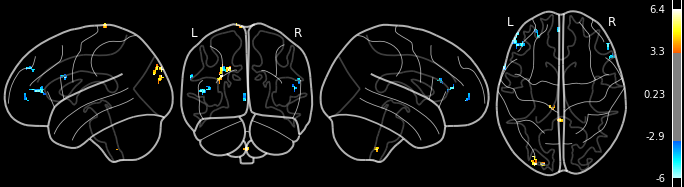

In [29]:
from IPython.display import Image
Image(os.path.join(outdir, "sub-06_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.png"))

Having explored this all in detail, let's take the short-cut of just using the glm report function and see what this function comes up with.

In [30]:
from nilearn.reporting import make_glm_report

report = make_glm_report(fmri_glm_run1_sub06, contrasts= active_learned_vs_foil,
                         bg_img=mean_img_run1_sub06)

Let's lastly look at the R-squared to see how much variance is explained. The R² is baded on the glm. 

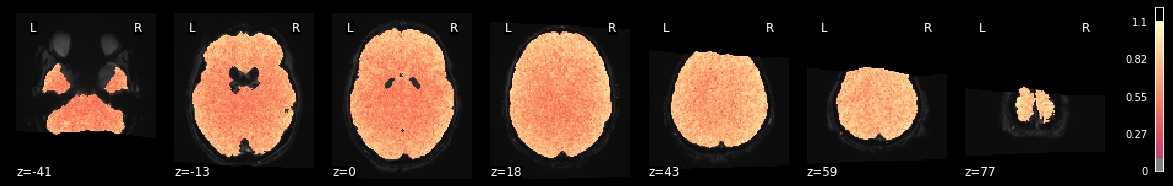

In [31]:
from nilearn import plotting
plotting.plot_stat_map(fmri_glm_run1_sub06.r_square[0], bg_img=mean_img_run1_sub06, threshold=.1,
                       display_mode='z', cut_coords=7, cmap='magma');

## Extending the GLM to the Other Runs

First I am loading all fmri-images and I am concatenating them. This first step will generate a list with all file paths for one participant. 

I will just do this for participant 6 in the beginning, and then create a `for` loop which extends this to every participant. 

In [ ]:
import os
import numpy as np
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
from nilearn.glm.first_level import FirstLevelModel
import nilearn.image as nli
import pandas as pd 

file_path = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data"

subject_test = "06"

In [ ]:
import os 
fmri_img_path= []
fmri_img_path_single = []
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/")
for i in os.listdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-%s" %(subject_test)):
    file_name = i
    if file_name.endswith("bold.nii.gz") and "scene" in file_name: 
         fmri_img_path.append(file_name)
    else:
         continue

Now, I have all the image paths. But the actual images still need to be attached to each other! This way, the confunds that do not change acrosss the runs can be modelled as continous.

Now, I should also append the confounds to each other. 

In [37]:
confounds = []
for run in ['01', '03', '04', '05', '06', '07']:
    # read in the confounds
    confounds_run = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject_test), "sub-%s_task-scene_run-%s_desc-confounds.tsv" %(subject_test, run)), 
                            delimiter = '\t')
    
    # restrict the to be included confounds to a subset
    confounds_run_glm = confounds_run[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
    confounds.append(confounds_run_glm)
    

Now the event files.

In [38]:
events = []
for run in ['01', '03', '04', '05', '06', '07']:
    # read in the events
    events_run = pd.read_table(os.path.join(file_path,"ds003707", "sub-%s" %(subject_test), "func", "sub-%s_task-scene_run-%s_events.tsv" %(subject_test, run)))
    
    #perform operations on the events table to make it fit the glm
    events_run = events_run[["onset", "duration", "trial_type"]]
 
    print("Run %s" %(run))
    
    events_runs_cor_name = events_run
    for i, row in events_run.iterrows():
        events_runs_cor_name["trial_type"][i] = events_run["trial_type"][i].replace('1_', 'Learned_')
        events_runs_cor_name["trial_type"][i] = events_run["trial_type"][i].replace('2_', 'Learned_')

    events.append(events_run)

Run 01
Run 03
Run 04
Run 05
Run 06
Run 07


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


 To use the [make_first_level_design_matrix](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html), I need to also define the frame rates. The repetition time I already know, I need to find out the number of scans to find out the frame-rate. 

In [39]:
from numpy import arange
T_R = 2.0
n_scans = 177
frame_times = arange(n_scans)*T_R

Next I will get the design matrix for every run.

In [40]:
from nilearn.glm.first_level import make_first_level_design_matrix
runs_numbered = ['01', '03', '04', '05', '06', '07']

design_matrix_all_runs = []
for runs_numbered , x in enumerate(runs_numbered ):
    design_matrix = make_first_level_design_matrix(frame_times, events[runs_numbered ], 
        drift_model='cosine',
        hrf_model='spm',
        high_pass= 1./128, 
        add_regs= confounds[runs_numbered ])
    design_matrix_all_runs.append(design_matrix)

Now I will fit the glm. As the HRF etc. was already specified in the first_level_design_matrix, I left it out for the FirstLevelModel. 

In [41]:
fmri_glm_loop = FirstLevelModel(t_r=2.0,
                           noise_model= 'ar1',
                           hrf_model= 'spm',
                           drift_model='cosine',
                           high_pass=1./128,
                           signal_scaling= False,
                           minimize_memory =  True,
                           memory = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/",
                           memory_level = 600000,
                           verbose = 3)

In [42]:
fmri_img_path = sorted(fmri_img_path)
fmri_img_path

['sub-36_task-scene_run-01_desc-preproc_bold.nii.gz',
 'sub-36_task-scene_run-03_desc-preproc_bold.nii.gz',
 'sub-36_task-scene_run-04_desc-preproc_bold.nii.gz',
 'sub-36_task-scene_run-05_desc-preproc_bold.nii.gz',
 'sub-36_task-scene_run-06_desc-preproc_bold.nii.gz',
 'sub-36_task-scene_run-07_desc-preproc_bold.nii.gz']

In [43]:
os.chdir(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject_test)))
glm = fmri_glm_loop.fit(fmri_img_path, design_matrices = design_matrix_all_runs)

[NiftiMasker.fit] Loading data from sub-36_task-scene_run-01_desc-preproc_bold.nii.gz
[NiftiMasker.fit] Computing the mask
________________________________________________________________________________
[Memory] Calling nilearn.masking.compute_epi_mask...
compute_epi_mask('sub-36_task-scene_run-01_desc-preproc_bold.nii.gz', verbose=0)
_________________________________________________compute_epi_mask - 5.2s, 0.1min
[NiftiMasker.fit] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min


Computing run 1 out of 6 runs (go take a coffee, a big one)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158f35b400>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-01_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158f35b400>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 6.4s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[3903.300681, ..., 5288.416046],
       ...,
       [4021.747049, ..., 5324.657098]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 21 seconds       


_________________________________________________filter_and_mask - 16.4s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[3903.300681, ..., 5288.416046],
       ...,
       [4021.747049, ..., 5324.657098]]), 
array([[0., ..., 1.],
       ...,
       [0., ..., 1.]]), noise_model='ar1', bins=100, n_jobs=1)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 7 seconds         
Computing run 2 out of 6 runs (171 seconds remaining)


__________________________________________________________run_glm - 6.9s, 0.1min


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158efb3358>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-03_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158efb3358>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 6.9s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[4174.704431, ..., 5066.732612],
       ...,
       [3992.244121, ..., 5109.042249]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 22 seconds       


_________________________________________________filter_and_mask - 17.0s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[4174.704431, ..., 5066.732612],
       ...,
       [3992.244121, ..., 5109.042249]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.005783, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=1)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 7 seconds         
Computing run 3 out of 6 runs (137 seconds remaining)


__________________________________________________________run_glm - 6.6s, 0.1min


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158f363080>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-04_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158f363080>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 7.1s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[4757.601328, ..., 5250.210586],
       ...,
       [4961.891552, ..., 5493.046136]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 22 seconds       


_________________________________________________filter_and_mask - 17.2s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[4757.601328, ..., 5250.210586],
       ...,
       [4961.891552, ..., 5493.046136]]), 
array([[0., ..., 1.],
       ...,
       [0., ..., 1.]]), noise_model='ar1', bins=100, n_jobs=1)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 8 seconds         
Computing run 4 out of 6 runs (104 seconds remaining)


__________________________________________________________run_glm - 7.0s, 0.1min


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158efb10f0>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-05_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158efb10f0>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 7.6s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[4044.686171, ..., 5826.961737],
       ...,
       [4609.654677, ..., 5125.064542]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 22 seconds       


_________________________________________________filter_and_mask - 17.6s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[4044.686171, ..., 5826.961737],
       ...,
       [4609.654677, ..., 5125.064542]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.060664, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=1)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 7 seconds         
Computing run 5 out of 6 runs (69 seconds remaining)


__________________________________________________________run_glm - 6.8s, 0.1min


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158f2f0208>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-06_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158f2f0208>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 7.7s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[4343.225337, ..., 5031.631251],
       ...,
       [4805.581395, ..., 4672.248903]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 23 seconds       


_________________________________________________filter_and_mask - 17.8s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[4343.225337, ..., 5031.631251],
       ...,
       [4805.581395, ..., 4672.248903]]), 
array([[ 0.      , ...,  1.      ],
       ...,
       [-0.052948, ...,  1.      ]]), noise_model='ar1', bins=100, n_jobs=1)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 8 seconds         
Computing run 6 out of 6 runs (35 seconds remaining)


__________________________________________________________run_glm - 7.1s, 0.1min


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7f158ef44160>, <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=600000, memory=Memory(location=/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/cache/joblib), verbose=1, confounds=None, sample_mask=None, copy=True, dtype=None)
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('sub-36_task-scene_run-07_desc-preproc_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Extracting region signals


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker.nifti_masker_extractor...
nifti_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f158ef44160>)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:96: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  memory_level=memory_level)(imgs)


___________________________________________nifti_masker_extractor - 7.6s, 0.1min
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[3872.197248, ..., 5514.584817],
       ...,
       [3914.581444, ..., 4754.212353]]), detrend=False, standardize=False, standardize_confounds=True, t_r=2.0, low_pass=None, high_pass=None, confounds=None, sample_mask=None, runs=None)


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/base_masker.py:119: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  runs=runs)


____________________________________________________________clean - 1.0s, 0.0min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/maskers/nifti_masker.py:486: UserWarning: Persisting input arguments took 2.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
Masker took 23 seconds       


_________________________________________________filter_and_mask - 17.7s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[3872.197248, ..., 5514.584817],
       ...,
       [3914.581444, ..., 4754.212353]]), 
array([[0., ..., 1.],
       ...,
       [0., ..., 1.]]), noise_model='ar1', bins=100, n_jobs=1)
__________________________________________________________run_glm - 6.9s, 0.1min


/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:589: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  bins=bins, n_jobs=self.n_jobs)
GLM took 7 seconds         

Computation of 6 runs done in 212 seconds



And now lets save this.

In [44]:
from numpy import array
array_learned = np.array([0]*design_matrix.shape[0])
                            
conditions = {
    'active - Learned': np.array([0]*design_matrix.shape[1]),
    'active - Foil':   np.array([0]*design_matrix.shape[1]),
}

i = 0
for col in design_matrix:
    if "foil" in col:     #Creating the contrast for the lure images. 
        conditions['active - Foil'][i] = 1
    elif "Learned_A" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    elif "Learned_B" in col: #Creating the contrast for the learned images.
        conditions['active - Learned'][i] = 1
    i = i+1   

active_learned_vs_foil = conditions['active - Learned'] - conditions['active - Foil']

outdir_path = os.path.join(file_path, "outputs", "results")

print("Creating z maps for %s" %(subject_test))
    # compute the contrast as a z-map
z_map = glm.compute_contrast(active_learned_vs_foil,
    output_type='z_score')
        
    #defining the folder, where the resulting zmap shall be stored. To make it more easily manually inspectable, a folder for each participant is created
if not os.path.exists(os.path.join(outdir_path, "sub-%s" %subject_test)):
    os.mkdir(os.path.join(outdir_path, "sub-%s" %subject_test))

for run_test in ['01', '03', '04', '05', '06', '07']:
    print("Saving z-maps %s, %s" %(subject_test, run_test))
    # save the z-map
    z_map.to_filename(os.path.join(outdir_path, "sub-%s" %subject_test, 'sub-%s_task-scene_run-%s_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz' %(subject_test, run_test)))

/home/tchaase/miniconda3/envs/msc5neuro/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Creating z maps for 36
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 1.556498, ..., -2.32296 ]), <nibabel.nifti1.Nifti1Image object at 0x7f158f2ff358>)
___________________________________________________________unmask - 0.1s, 0.0min
Saving z-maps 36, 01
Saving z-maps 36, 03
Saving z-maps 36, 04
Saving z-maps 36, 05
Saving z-maps 36, 06
Saving z-maps 36, 07


Here is the loop to attempt this for all participants.

In [ ]:
import os 
fmri_img_path= []
os.chdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/")

for subject in ['03']:
    print("Getting path for %s" %(subject))
    
    #Getting the file paths
    for i in os.listdir("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-%s" %(subject)):
        file_name = i
        if file_name.endswith("bold.nii.gz") and "scene" in file_name: 
             fmri_img_path.append(file_name)
        else:
             continue
    fmri_img_path = sorted(fmri_img_path)
    print("Getting the confounds for %s" %(subject))            
    #Getting and appending the confounds
    confounds = []
    for run in ['01', '03', '04', '05', '06', '07']:
    # read in the confounds
        confounds_run = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-confounds.tsv" %(subject, run)), 
                            delimiter = '\t')
    
    # restrict the to be included confounds to a subset
        confounds_run_glm = confounds_run[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
        confounds.append(confounds_run_glm)
        
    print("Getting the events for %s" %(subject))  
    events = []
    for run in ['01', '03', '04', '05', '06', '07']:
        # read in the events
        events_run = pd.read_table(os.path.join(file_path,"ds003707", "sub-%s" %(subject), "func", "sub-%s_task-scene_run-%s_events.tsv" %(subject, run)))
    
        #perform operations on the events table to make it fit the glm
        events_run = events_run[["onset", "duration", "trial_type"]]
 
        print("Run %s" %(run))
    
        events_runs_cor_name = events_run
        for i, row in events_run.iterrows():
            events_runs_cor_name["trial_type"][i] = events_run["trial_type"][i].replace('1_', 'Learned_')
            events_runs_cor_name["trial_type"][i] = events_run["trial_type"][i].replace('2_', 'Learned_')

        events.append(events_run)
    
    
    print("Creating the design-matrix for %s" %(subject))
    #Getting the frame rates for design matrix. 
    from numpy import arange
    T_R = 2.0
    fmri_img_path_single = os.path.join("/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/fmri-prep_20.2.3-2/sub-%s" %(subject), fmri_img_path[1])
    fmri_img_run = nib.load(fmri_img_path_single)
    n_scans = fmri_img_run.shape[3]
    frame_times = arange(n_scans)*T_R
    
    from nilearn.glm.first_level import make_first_level_design_matrix
    runs_numbered = ['01', '03', '04', '05', '06', '07']

    design_matrix_all_runs = []
    for runs_numbered , x in enumerate(runs_numbered ):
        design_matrix = make_first_level_design_matrix(frame_times, 
            events[runs_numbered ], 
            drift_model='cosine',
            hrf_model='spm',
            high_pass= 1./128, add_regs= confounds[runs_numbered ])
        design_matrix_all_runs.append(design_matrix)
    
    print("Fitting the glm for %s" %(subject))
    
    #fitting the glm
    os.chdir(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject)))
    fmri_glm_loop_fitted = fmri_glm_loop.fit(fmri_img_path, design_matrices = design_matrix_all_runs)
    
    print("Creating z maps for %s" %(subject))
    # compute the contrast as a z-map
    z_map = fmri_glm_loop_fitted.compute_contrast(active_learned_vs_foil,
                                  output_type='z_score')
        
    #defining the folder, where the resulting zmap shall be stored. To make it more easily manually inspectable, a folder for each participant is created
    if not os.path.exists(os.path.join(outdir_path, "sub-%s" %subject)):
        os.mkdir(os.path.join(outdir_path, "sub-%s" %subject))
    
    print("Saving z-maps %s" %(subject))
    # save the z-map
    z_map.to_filename(os.path.join(outdir_path, "sub-%s" %subject, 'sub-%s_task-scene_run-%s_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz' %(subject, run)))
    

Here is the list of all participants for the rare occasion this does not crash and I get to run all participants at once!

In [ ]:
complete_subjects = ['03', '06', '08', '09', '10', '11', '12', '14', '19', '20', '22', '23', '24', '25', '27','28', '34', '35', '36']

As it seems my device is unable to handle the memory load. I am therefore going to take a shortcut in order to get to the machine learning section. 

In [ ]:
file_path = "/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data"
for subject in ['03']:
    print("Now calculating %s" % subject)
    mean_image 
    for run in ['01', '03', '04', '05', '06', '07']:
        print("For %s, now calculating run %s" %(subject, run))
        #Setting the paths
        fmri_img_path = os.path.join(file_path, "outputs/fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-preproc_bold.nii.gz" %(subject, run))
        anat__img_path = os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-preproc_T1w.nii.gz" %(subject, run))
    
        # read in the events
        events = pd.read_table(os.path.join(file_path,"ds003707", "sub-%s" %(subject), "func", "sub-%s_task-scene_run-%s_events.tsv" %(subject, run)))
    
        #perform operations on the events table to make it fit the glm
        events = events[["onset", "duration", "trial_type"]]
        for i, row in events.iterrows():
            events["trial_type"][i] = events["trial_type"][i].replace('1_', 'Learned_')
            events["trial_type"][i] = events["trial_type"][i].replace('2_', 'Learned_')
    
        # read in the confounds
        confounds = pd.read_csv(os.path.join(file_path, "outputs", "fmri-prep_20.2.3-2", "sub-%s" %(subject), "sub-%s_task-scene_run-%s_desc-confounds.tsv" %(subject, run)), 
                                  delimiter = '\t')
    
        # restrict the to be included confounds to a subset
        confounds_glm = confounds[['white_matter', 'global_signal', 'framewise_displacement','csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'rmsd']].replace(np.nan, 0)
    
        # run the GLM
        fmri_glm = fmri_glm.fit(fmri_img_path, events, confounds_glm)
    
        # compute the contrast as a z-map
        z_map = fmri_glm.compute_contrast(active_learned_vs_foil,
                                  output_type='z_score')
        
        #defining the folder, where the resulting zmap shall be stored. To make it more easily manually inspectable, a folder for each participant is created
        if not os.path.exists(os.path.join(outdir_path, "sub-%s" %subject)):
            os.mkdir(os.path.join(outdir_path, "sub-%s" %subject))
        
        # save the z-map
        z_map.to_filename(os.path.join(outdir_path, "sub-%s" %test, 'sub-%s_task-scene_run-%s_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz' %(subject, run)))

## Second Level Model

The next goal is to perform a group-level model. For every subject, the contrasts were defined. 

First, the individual contrast maps need to be gathered. 

In [30]:
from glob import glob
list_z_maps = glob(os.path.join(outdir_path, "sub-*" , 'sub-*_task-scene_run-*_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz'))

list_z_maps

['/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-03_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz',
 '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-01_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz',
 '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-06_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz',
 '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-05_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz',
 '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-07_space-MNI152nlin2009casym_desc-learnedvsfoil_zmap.nii.gz',
 '/home/tchaase/Documents/Universitaet/Forschungsmodul/project/data/outputs/results/sub-24/sub-24_task-scene_run-04_space-MNI

The list of z-map appears complete. Now, I will create a second level design matrix. 

In [32]:
design_matrix_second_level = pd.DataFrame([1] * len(list_z_maps), columns=['intercept'])
design_matrix_second_level

,intercept
0,1
1,1
2,1
3,1
4,1
...,...
109,1
110,1
111,1
112,1


In [33]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(list_z_maps,
                                            design_matrix=design_matrix_second_level)

Now, lets plot this!

In [ ]:
z_map_group = second_level_model.compute_contrast(output_type='z_score')

Disclaimer: My kernel always dies currently when trying to run this. I will have to solve this in the future.

## Future Directions

Following this, I want to use machine learning to further analyze this data.

Before I can progress further, I need to decide on how to crossvalidate. 
The stimuli are the same across runs and across people. There are two options:
1. Use a certain number of runs and cross-validate by using runs from every participants. 
2. Use a certain amount of participants to cross-validate. 

As I have data for a few participants and I don't want to overfit by testing and fitting on the same participants, I choose to use a certain amount of participants to cross-validate.